In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils.load_preprocess import *
import missingno as msno

In [2]:
news_df = pd.read_table('./data/train/news.tsv', sep='\t',header=None)
news_df.drop(news_df.columns[5:8],
             axis=1,
             inplace=True)
news_df = news_df.rename(columns={0: 'news_id',
                                  1: 'category',
                                  2: 'subcategory',
                                  3: 'title',
                                  4: 'abstract'})
# set news_id as index
news_df.set_index('news_id', inplace=True)
news_df.head()

,category,subcategory,title,abstract
news_id,,,,
N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...
N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi..."
N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re..."


In [3]:
# count unique index
len(news_df.index.unique())

51282

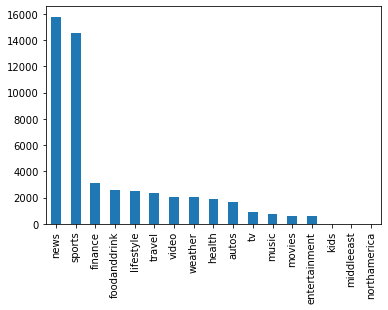

In [4]:
# count unique category
len(news_df['category'].unique())
# plot category distribution
news_df['category'].value_counts().plot(kind='bar')
plt.show()

In [5]:
news_df.describe()

,category,subcategory,title,abstract
count,51282,51282,51282,48616
unique,17,264,50434,47309
top,news,newsus,Photos of the Day,What's the weather today? What's the weather f...
freq,15774,6564,15,124


We Can notice a lot of abstracts are empty.This won't affect our analysis since we are going to use TF-IDF to extract features only from titles.

In [6]:
behave_df = pd.read_table('./data/train/behaviors.tsv', sep='\t', header=None )
behave_df.drop([0, 2],
               axis=1,
               inplace=True)
behave_df.columns = ['user_id', 'history', 'impressions']
# set user_id as index
# behave_df.set_index('user_id', inplace=True)

In [7]:
behave_df

,user_id,history,impressions
0,U13740,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,U91836,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,U73700,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,U34670,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,U8125,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...
...,...,...,...
156960,U21593,N7432 N58559 N1954 N43353 N14343 N13008 N28833...,N2235-0 N22975-0 N64037-0 N47652-0 N11378-0 N4...
156961,U10123,N9803 N104 N24462 N57318 N55743 N40526 N31726 ...,N3841-0 N61571-0 N58813-0 N28213-0 N4428-0 N25...
156962,U75630,N29898 N59704 N4408 N9803 N53644 N26103 N812 N...,N55913-0 N62318-0 N53515-0 N10960-0 N9135-0 N5...
156963,U44625,N4118 N47297 N3164 N43295 N6056 N38747 N42973 ...,N6219-0 N3663-0 N31147-0 N58363-0 N4107-0 N457...


In [8]:
# count unique index
print(behave_df.shape[0])
len(behave_df['user_id'].unique())

156965


50000

In [9]:
behave_df = behave_df.groupby('user_id').agg(sum).reset_index()

In [10]:
behave_df

,user_id,history,impressions
0,U100,N20121 N33998 N45954 N55743 N50095 N18870 N534...,N61235-0 N54489-0 N42597-0 N7800-1 N61408-0 N2...
1,U1000,N29641 N1789 N41244N29641 N1789 N41244N29641 N...,N16148-0 N43628-0 N13094-0 N32774-0 N57034-0 N...
2,U10001,N47937 N51706 N56447 N61319 N27644 N18030 N272...,N42860-0 N62750-0 N33025-0 N3167-0 N51975-0 N4...
3,U10003,N39074 N26619 N31431 N1282 N61052 N41668 N5083...,N58710-0 N39770-0 N33964-0 N64009-0 N36692-0 N...
4,U10008,N23912 N30148 N46754 N33117 N9619 N36526 N4449...,N24272-0 N8016-0 N43595-0 N732-0 N8929-0 N3567...
...,...,...,...
49995,U9993,N47458 N14114,N28918-0 N53515-0 N34869-0 N37204-0 N15574-0 N...
49996,U9995,N61471 N61704 N49103 N63554 N44399 N32117 N218...,N47098-0 N50872-0 N44698-0 N55943-0 N496-0 N15...
49997,U9996,N28296 N4719 N60340 N31165 N8448N28296 N4719 N...,N287-1 N64094-0 N51048-0 N39010-0N38779-0 N153...
49998,U9997,N46759 N46990 N9072 N11727 N50744 N38367 N3333...,N35273-0 N4510-0 N48410-1 N29170-0 N26262-0 N5...


In [11]:
# print number of emprt history
print('number of empty history users: ', behave_df.loc[behave_df['history'] == 0].shape[0])
# behave_df['history'] = behave_df['history'].replace(0, '')
# convert history to list
# behave_df['history'] = behave_df['history'].apply(lambda x: x.split(' '))

number of empty history users:  892


In [12]:
# print number of emprt history
print('number of empty impressions users: ', behave_df.loc[behave_df['impressions'] == 0].shape[0])
behave_df['impressions'] = behave_df['impressions'].replace(0, '')
# convert history to list
behave_df['impressions'] = behave_df['impressions'].apply(lambda x: x.split(' '))

number of empty impressions users:  0


In [13]:
behave_df

,user_id,history,impressions
0,U100,N20121 N33998 N45954 N55743 N50095 N18870 N534...,"[N61235-0, N54489-0, N42597-0, N7800-1, N61408..."
1,U1000,N29641 N1789 N41244N29641 N1789 N41244N29641 N...,"[N16148-0, N43628-0, N13094-0, N32774-0, N5703..."
2,U10001,N47937 N51706 N56447 N61319 N27644 N18030 N272...,"[N42860-0, N62750-0, N33025-0, N3167-0, N51975..."
3,U10003,N39074 N26619 N31431 N1282 N61052 N41668 N5083...,"[N58710-0, N39770-0, N33964-0, N64009-0, N3669..."
4,U10008,N23912 N30148 N46754 N33117 N9619 N36526 N4449...,"[N24272-0, N8016-0, N43595-0, N732-0, N8929-0,..."
...,...,...,...
49995,U9993,N47458 N14114,"[N28918-0, N53515-0, N34869-0, N37204-0, N1557..."
49996,U9995,N61471 N61704 N49103 N63554 N44399 N32117 N218...,"[N47098-0, N50872-0, N44698-0, N55943-0, N496-..."
49997,U9996,N28296 N4719 N60340 N31165 N8448N28296 N4719 N...,"[N287-1, N64094-0, N51048-0, N39010-0N38779-0,..."
49998,U9997,N46759 N46990 N9072 N11727 N50744 N38367 N3333...,"[N35273-0, N4510-0, N48410-1, N29170-0, N26262..."


In [14]:
res = behave_df.explode('impressions')

In [15]:
# add a column for res contiaining the last char of the impressions
res['label'] = res['impressions'].apply(lambda x: x[-1])

In [16]:
# strip the 2 last char of the impressions
res['impressions'] = res['impressions'].apply(lambda x: x[:-2])

In [17]:
res

,user_id,history,impressions,label
0,U100,N20121 N33998 N45954 N55743 N50095 N18870 N534...,N61235,0
0,U100,N20121 N33998 N45954 N55743 N50095 N18870 N534...,N54489,0
0,U100,N20121 N33998 N45954 N55743 N50095 N18870 N534...,N42597,0
0,U100,N20121 N33998 N45954 N55743 N50095 N18870 N534...,N7800,1
0,U100,N20121 N33998 N45954 N55743 N50095 N18870 N534...,N61408,0
...,...,...,...,...
49999,U9999,N64503 N20039 N447 N10865 N59026 N12972 N25577...,N41224,0
49999,U9999,N64503 N20039 N447 N10865 N59026 N12972 N25577...,N27349,0
49999,U9999,N64503 N20039 N447 N10865 N59026 N12972 N25577...,N61022,1
49999,U9999,N64503 N20039 N447 N10865 N59026 N12972 N25577...,N11830,0


In [18]:
# find duplicate rows in res
res.duplicated().sum()

745756

In [19]:
# remove duplicate rows
res.drop_duplicates(inplace=True)

In [20]:
res

,user_id,history,impressions,label
0,U100,N20121 N33998 N45954 N55743 N50095 N18870 N534...,N61235,0
0,U100,N20121 N33998 N45954 N55743 N50095 N18870 N534...,N54489,0
0,U100,N20121 N33998 N45954 N55743 N50095 N18870 N534...,N42597,0
0,U100,N20121 N33998 N45954 N55743 N50095 N18870 N534...,N7800,1
0,U100,N20121 N33998 N45954 N55743 N50095 N18870 N534...,N61408,0
...,...,...,...,...
49999,U9999,N64503 N20039 N447 N10865 N59026 N12972 N25577...,N41224,0
49999,U9999,N64503 N20039 N447 N10865 N59026 N12972 N25577...,N27349,0
49999,U9999,N64503 N20039 N447 N10865 N59026 N12972 N25577...,N61022,1
49999,U9999,N64503 N20039 N447 N10865 N59026 N12972 N25577...,N11830,0
